Original source for majority of the code below is d2l.ai, but some codes are modified to make them fit better to the class contents and be independent of the d2l library for better understanding of the coding principles.

Dr. Ulya Bayram

# Gradient Descent

## One-Dimensional Gradient Descent




In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def f(x):  # Objective function
    return x ** 2

def f_grad(x):  # Gradient (derivative) of the objective function
    return 2*x

Next, we use $x=10$ as the initial value and assume $\eta=0.2$. Using gradient descent to iterate $x$ for 10 times we can see that, eventually, the value of $x$ approaches the optimal solution.


In [3]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


In [4]:
results

[10.0,
 6.0,
 3.5999999999999996,
 2.1599999999999997,
 1.2959999999999998,
 0.7775999999999998,
 0.46655999999999986,
 0.2799359999999999,
 0.16796159999999993,
 0.10077695999999996,
 0.06046617599999997]

The progress of optimizing over $x$ can be plotted as follows.


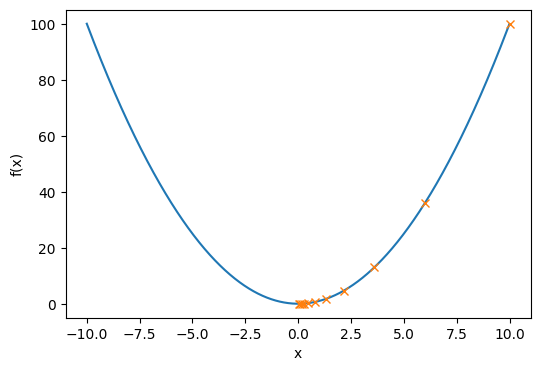

In [5]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    plt.figure(figsize=(6, 4))
    plt.plot(f_line, [f(x) for x in f_line], '-', label='f(x)')
    plt.plot(results, [f(x) for x in results], 'x', label='f(x)', linestyle='None')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.show()

show_trace(results, f)

### Learning Rate

Too small?


epoch 10, x: 1.073742


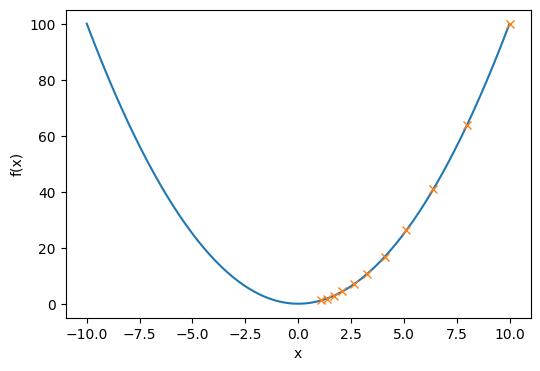

In [11]:
show_trace(gd(0.1, f_grad), f)

Too large?


epoch 10, x: 1.073742


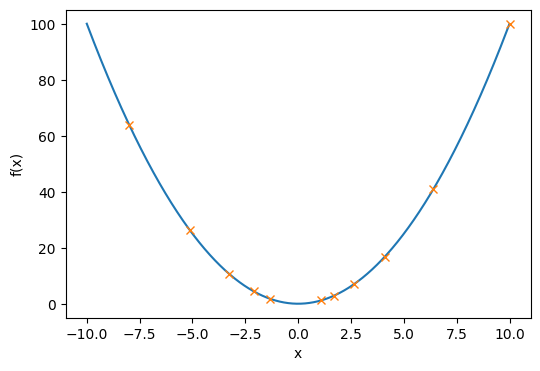

In [14]:
show_trace(gd(0.9, f_grad), f)

### Local Minima

To illustrate what happens for nonconvex functions consider the case of $f(x) = x \cdot \cos(cx)$ for some constant $c$. This function has infinitely many local minima. Depending on our choice of the learning rate and depending on how well conditioned the problem is, we may end up with one of many solutions. The example below illustrates how an (unrealistically) high learning rate will lead to a poor local minimum.


epoch 10, x: 7.295479


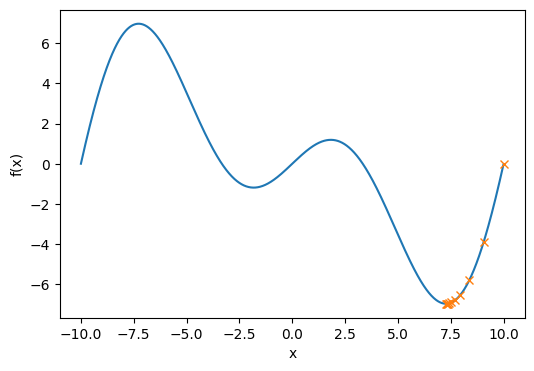

In [20]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(0.2, f_grad), f)

## Multivariate Gradient Descent

To see how the algorithm behaves in practice let's construct an objective function $f(\mathbf{x})=x_1^2+2x_2^2$ with a two-dimensional vector $\mathbf{x} = [x_1, x_2]^\top$ as input and a scalar as output. The gradient is given by $\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$. We will observe the trajectory of $\mathbf{x}$ by gradient descent from the initial position $[-5, -2]$.

To begin with, we need two more helper functions. The first uses an update function and applies it 20 times to the initial value. The second helper visualizes the trajectory of $\mathbf{x}$.


In [21]:
#@ save
def train_2d(trainer, steps=20, f_grad=None):  
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    plt.figure(figsize=(6, 4))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1), torch.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

Next, we observe the trajectory of the optimization variable $\mathbf{x}$ for learning rate $\eta = 0.1$. We can see that after 20 steps the value of $\mathbf{x}$ approaches its minimum at $[0, 0]$. Progress is fairly well-behaved albeit rather slow.


epoch 20, x1: -0.000183, x2: -0.000000


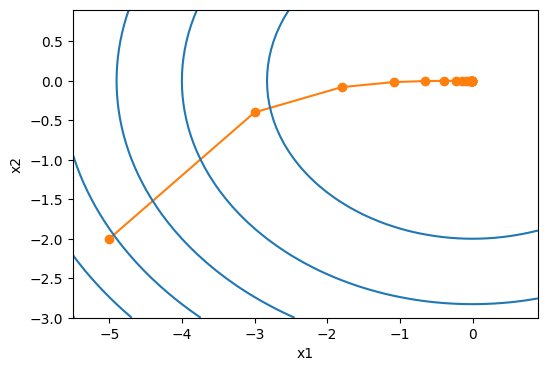

In [28]:
def f_2d(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # Gradient of the objective function
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.2
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

## Adaptive Methods

### Newton's Method

Let's see what happens in other problems.
Given a convex hyperbolic cosine function $f(x) = \cosh(cx)$ for some constant $c$, we can see that
the global minimum at $x=0$ is reached
after a few iterations.


epoch 10, x: tensor(0.)


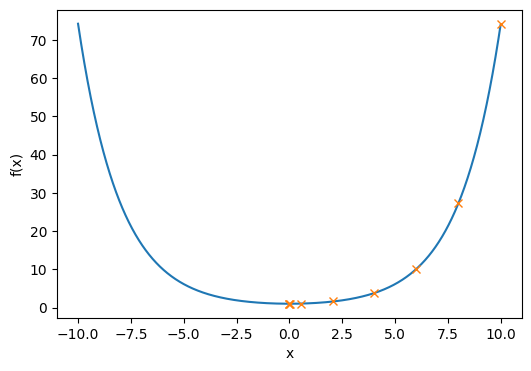

In [59]:
c = torch.tensor(0.5)

def f(x):  # Objective function
    return torch.cosh(c * x)

def f_grad(x):  # Gradient of the objective function
    return c * torch.sinh(c * x)

def f_hess(x):  # Hessian of the objective function
    return c**2 * torch.cosh(c * x)

def newton(x, n_epochs, eta=1):

    results = [x]
    for i in range(n_epochs):
        x -= eta*f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

results = newton(10, 8)
show_trace(results, f)

In [38]:
results

[10.0,
 8.000182151794434,
 6.001523494720459,
 4.011399269104004,
 2.08254337310791,
 0.5257638692855835,
 0.011785626411437988,
 1.3690441846847534e-07,
 0.0]

Now let's consider a *nonconvex* function, such as $f(x) = x \cos(c x)$ for some constant $c$. After all, note that in Newton's method we end up dividing by the Hessian. This means that if the second derivative is *negative* we may walk into the direction of *increasing* the value of $f$.
That is a fatal flaw of the algorithm.
Let's see what happens in practice.


epoch 10, x: tensor(26.8341)


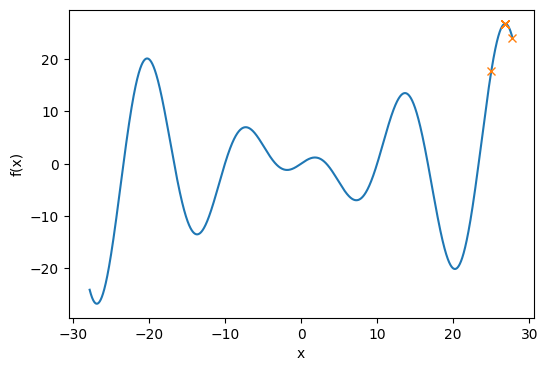

[25,
 27.77294158935547,
 26.801597595214844,
 26.83417510986328,
 26.834131240844727,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.834133148

In [50]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # Hessian of the objective function
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

results = newton(25,200)
show_trace(results, f)

results

This went spectacularly wrong. How can we fix it? One way would be to "fix" the Hessian by taking its absolute value instead. Another strategy is to bring back the learning rate. This seems to defeat the purpose, but not quite. Having second-order information allows us to be cautious whenever the curvature is large and to take longer steps whenever the objective function is flatter.
Let's see how this works with a slightly smaller learning rate, say $\eta = 0.5$. As we can see, we have quite an efficient algorithm.


epoch 10, x: tensor(13.6604)


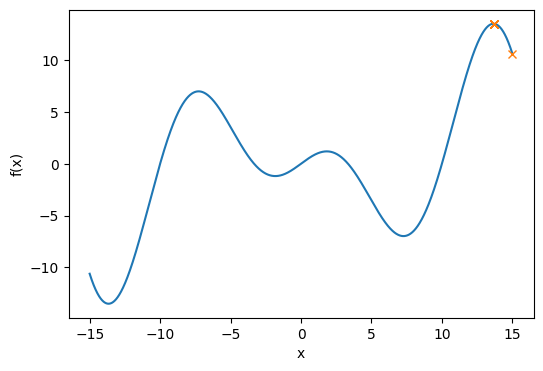

[25,
 27.77294158935547,
 26.801597595214844,
 26.83417510986328,
 26.834131240844727,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.83413314819336,
 26.834133148

In [57]:
show_trace(newton(15,10, 0.9), f)
results

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=700e962d-3fcf-4c82-8c8d-f1f2cc26fdf7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>